In [124]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

### Define fucntions to do necessary operations for creating Random Forest

In [125]:
#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

In [126]:
## EVERYTHING THAT NEEDS CHANGED SHOULD BE IN HERE

#define number of random states
number_of_random_states=5

#define intervals of test size
intervals=9 # 1:50%, 3:25%, 4:20%, 9:10%, 19:5%, 24:4%, 49:2%, 99:1%

#x-axis
if intervals==1:
    sample_size=[50] #50% intervals
elif intervals==3:
    sample_size=list(range(25,76,25)) #25% intervals
elif intervals==4:
    sample_size=list(range(20,81,20)) #20% intervals 
elif intervals==9:
    sample_size=list(range(10,91,10)) #10% intervals
elif intervals==19:
    sample_size=list(range(5,96,5)) #5% intervals
elif intervals==24:
    sample_size=list(range(4,97,4)) #4% intervals
elif intervals==49:
    sample_size=list(range(2,99,2)) #2% intervals
elif intervals==99:
    sample_size=list(range(1,100,1)) #1% intervals

### Train, Predict, and Plot

In [127]:
#read data file
data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
#add k*exp column
change_np(data)
#remove columns that are not needed
data = data.drop(columns=['scattering_angle', 'statistical_error', 'systematic_error', 'normalization', 'experimental_value', 'reaction_type'])

#One-hot encode
features = pd.get_dummies(data)
# Labels are the values we want to predict
labels = np.array(features['K_experimental_value'])
# Remove the labels from the features
features = features.drop('K_experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 2
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size/2), interval_size))
for value in range(0, 350 + int(interval_size/2), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)

Text(0.5, 1.0, 'NP SGTT Predictions')

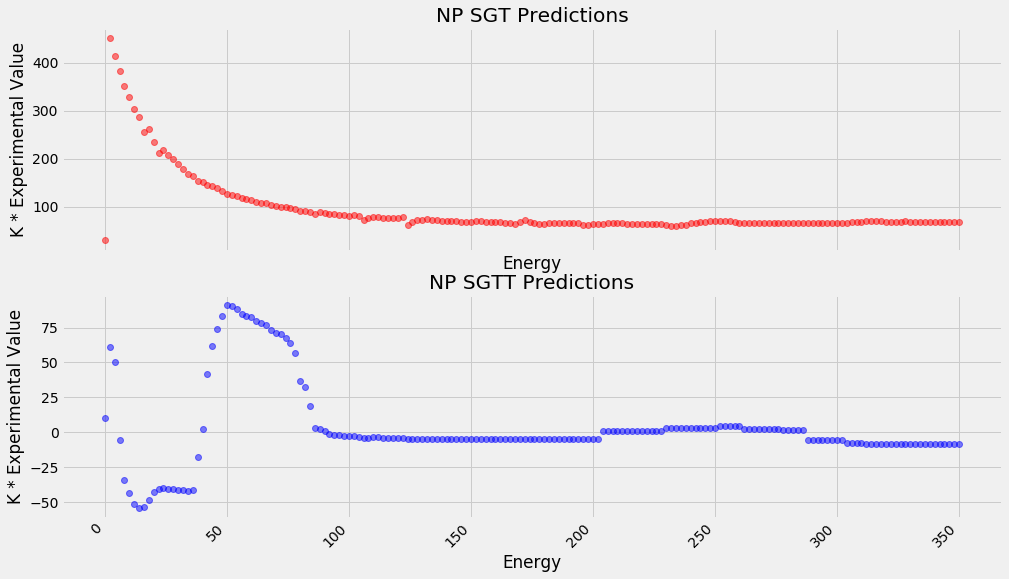

In [139]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)
#plot 1
ax1.plot(E, SGT_predictions, 'ro', alpha=0.5)
ax1.set_xlabel('Energy'); ax1.set_ylabel('K * Experimental Value'); ax1.set_title('NP SGT Predictions')
#plot 2
ax2.plot(E, SGTT_predictions, 'bo', alpha=0.5)
ax2.set_xlabel('Energy'); ax2.set_ylabel('K * Experimental Value'); ax2.set_title('NP SGTT Predictions')

### Random Data

In [129]:
#random data
random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
random_data = random_data.drop(columns=["reaction_type"])
random_data.rename(columns={' energy':'energy'}, inplace=True)
random_data['K_experimental_value'] = random_data.apply(lambda row: (row.experimental_value * row.k),axis=1)
random_data = random_data.drop(columns=['k', 'experimental_value', 'sigma'])
#experimental data
exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
change_np(exp_data)
exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'statistical_error', 'systematic_error', 'experimental_value', 'reaction_type'])
#combine
combined_data = pd.concat([random_data, exp_data], sort=True)
combined_data.head(4)

,K_experimental_value,energy,observable
0,65.336791,238.226430,SGT
1,164.352766,35.918331,SGT
2,66.506109,181.784790,SGT
3,65.750134,264.710330,SGT


Text(0.5, 1.0, 'NP SGTT Predictions')

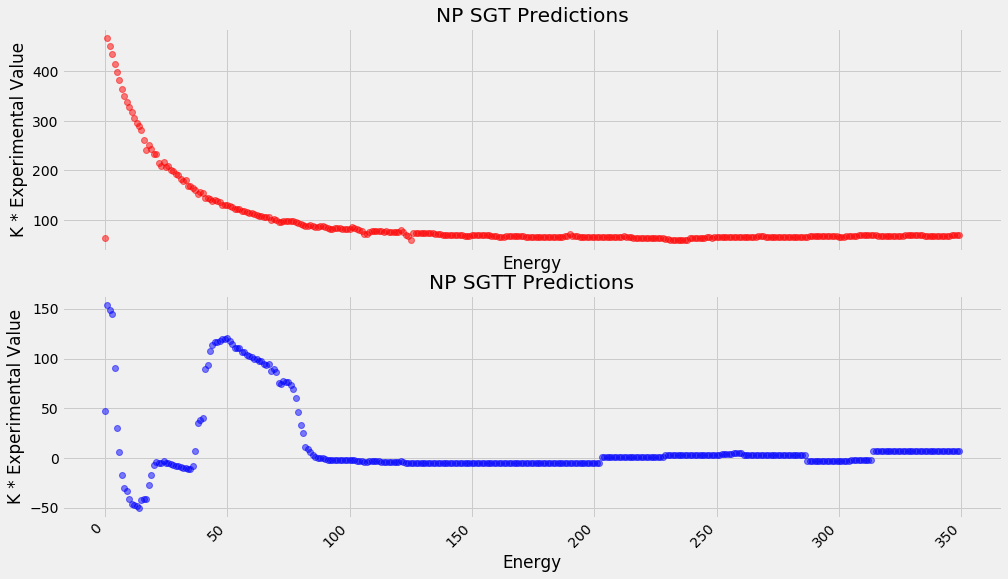

In [140]:
#One-hot encode
features = pd.get_dummies(data)
# Labels are the values we want to predict
labels = np.array(features['K_experimental_value'])
# Remove the labels from the features
features = features.drop('K_experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size/2), interval_size))
for value in range(0, 350 + int(interval_size/2), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)
#plot 1
ax1.plot(E, SGT_predictions, 'ro', alpha=0.5)
ax1.set_xlabel('Energy'); ax1.set_ylabel('K * Experimental Value'); ax1.set_title('NP SGT Predictions')
#plot 2
ax2.plot(E, SGTT_predictions, 'bo', alpha=0.5)
ax2.set_xlabel('Energy'); ax2.set_ylabel('K * Experimental Value'); ax2.set_title('NP SGTT Predictions')

### Gaussian Random Factor 

In [154]:
#random data
random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
random_data = random_data.drop(columns=["reaction_type"])
random_data.rename(columns={' energy':'energy'}, inplace=True)
#random_data['K_experimental_value'] = random_data.apply(lambda row: (row.experimental_value * row.k),axis=1)
random_data = random_data.drop(columns=['k'])
random_data.head(4)

,energy,experimental_value,sigma,observable
0,238.226430,38.565598,0.039539,SGT
1,35.918331,249.836690,0.153506,SGT
2,181.784790,44.938652,0.039841,SGT
3,264.710330,36.817009,0.039069,SGT


In [155]:
#experimental data
exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
#change_np(exp_data)
exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type'])
exp_data.head(4)

,energy,experimental_value,statistical_error,observable,systematic_error
0,0.000001,20436.0,23.0,SGT,0.0
1,0.000100,20491.0,14.0,SGT,0.0
2,0.000400,20436.0,23.0,SGT,0.0
3,0.001970,20130.0,30.0,SGT,0.0


In [160]:
#combine
combined_data = pd.concat([random_data, exp_data], sort=True)
combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
combined_data['k_exp'] = combined_data.apply(lambda row: row.k * row.experimental_value, axis=1)
combined_data['k_sigma'] = combined_data.apply(lambda row: row.k * row.sigma, axis=1)
combined_data['k_exp_plus_k_sigma'] = combined_data.apply(lambda row: row.k * (row.experimental_value + row.sigma), axis=1)
combined_data['k_exp_minus_k_sigma'] = combined_data.apply(lambda row: row.k * (row.experimental_value - row.sigma), axis=1)
combined_data['k_exp_plus_k_gauss_sigma'] = combined_data.apply(lambda row: row.k * (row.experimental_value + np.random.normal(row.experimental_value, row.sigma, 1)*row.sigma), axis=1)
combined_data

,energy,experimental_value,observable,sigma,statistical_error,systematic_error,k,k_exp,k_sigma,k_exp_plus_k_sigma,k_exp_minus_k_sigma,k_exp_plus_k_gauss_sigma
0,238.226430,38.565598,SGT,0.039539,NaN,NaN,1.694173,65.336800,0.066987,65.403787,65.269814,[67.91741106255742]
1,35.918331,249.836690,SGT,0.153506,NaN,NaN,0.657841,164.352802,0.100983,164.453785,164.251820,[189.61358721547774]
2,181.784790,44.938652,SGT,0.039841,NaN,NaN,1.479931,66.506124,0.058962,66.565086,66.447161,[69.15288185981196]
3,264.710330,36.817009,SGT,0.039069,NaN,NaN,1.785864,65.750153,0.069771,65.819925,65.680382,[68.32770697636958]
4,116.194210,64.476471,SGT,0.051310,NaN,NaN,1.183192,76.288017,0.060710,76.348727,76.227307,[80.20428421320338]
5,87.242203,86.579865,SGT,0.067500,NaN,NaN,1.025241,88.765262,0.069204,88.834466,88.696058,[94.76052369027558]
6,15.153592,643.083010,SGT,0.205447,NaN,NaN,0.427288,274.781603,0.087785,274.869388,274.693818,[331.23946983461116]
7,75.797943,101.496520,SGT,0.079000,NaN,NaN,0.955634,96.993512,0.075495,97.069007,96.918017,[104.66067823869083]
8,311.135830,34.693943,SGT,0.046173,NaN,NaN,1.936145,67.172498,0.089397,67.261895,67.083100,[70.27848959213411]
9,322.552890,34.286373,SGT,0.051657,NaN,NaN,1.971348,67.590372,0.101834,67.692206,67.488538,[71.08844593473138]


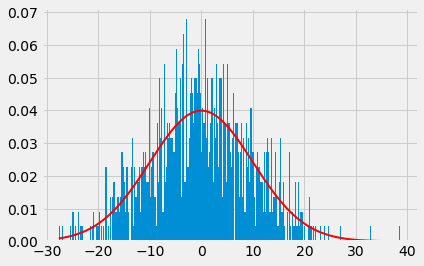

In [134]:
mu, sigma = 0.0, 10
s = np.random.normal(mu, sigma, 10**3)

count, bins, ignored = plt.hist(s, 300, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()